# Final Project - Basics of deep learning - TRANSFER EARNING


---
<br>

### Name and ID:
Student : Hod Haim 209369941
<br>


**SECTION 1: IMPORT LIBRARIES**


In [ ]:
# =============================
# SECTION 1: IMPORT LIBRARIES
# =============================

import os
import shutil
import kagglehub
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Install additional dependencies
!pip install ipython-autotime --quiet
!pip install gdown --upgrade --quiet
%load_ext autotime



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.8 MB/s eta 0:00:00
time: 262 µs (started: 2025-02-27 19:06:27 +00:00)


**SECTION 2:Explainer && Load and Preprocess Dataset**

In [ ]:
# SECTION 2: Load and Preprocess Dataset
# ======================================


###################################################Explainer#########################################################
# Install gdown if not installed
!pip install gdown --quiet

# Download the file using gdown
!gdown --id 1a3L8dxyiwBG6zf_MzuTegmiUMoOmXIoG -O explainer_transer_learning.zip

# Unzip the downloaded file
!unzip -o explainer_transer_learning.zip

# Verify that the file is extracted
!ls -l explainer_transer_learning.md
############################################################################################################################


# Step 1: Download metadata file (Excel) from Google Drive
DATASET_ID = "10f-OkhFIv1p5IOtY7NBM31n52Ndt7CjS"
DATASET_ZIP = "stanford_cars_with_class_names.zip"
DATASET_EXCEL = "stanford_cars_with_class_names.xlsx"

# Download and unzip dataset metadata
!gdown {DATASET_ID} -O {DATASET_ZIP}
!unzip -q {DATASET_ZIP} -d /content/dataset

# Step 2: Download dataset images from KaggleHub
!mkdir -p /content/dataset
path = kagglehub.dataset_download("jessicali9530/stanford-cars-dataset")
!mv /root/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/* /content/dataset

# Step 3: Load dataset metadata (Excel)
metadata_path = "/content/dataset/" + DATASET_EXCEL
xls = pd.ExcelFile(metadata_path)

# Load train and test datasets
train_df = pd.read_excel(xls, sheet_name="train")
test_df = pd.read_excel(xls, sheet_name="test")

# Step 4: Load annotations from the `.mat` file
annotations_path = "/content/dataset/cars_annos.mat"
metadata = scipy.io.loadmat(annotations_path)
annotations = metadata["annotations"]
class_names = metadata["class_names"]

# Convert class names to a list
class_names_list = [name[0] for name in class_names[0]]

# Step 5: Extract class labels and image paths
def extract_annotations(df):
    annotations = []
    class_names = np.empty(196, dtype=object)
    for _, row in df.iterrows():
        image_path = row["image"]
        class_num = int(row["class"]) - 1
        class_name = row["ture_class_name"]
        class_names[class_num] = class_name
        annotations.append((image_path, class_num))
    return annotations, class_names

# Extract annotations for train and test sets
train_annotations, train_class_names = extract_annotations(train_df)
test_annotations, test_class_names = extract_annotations(test_df)

# Step 6: Function to extract image paths and labels
def get_image_paths_and_labels(df, dataset_type="cars_train"):
    image_paths = []
    labels = []

    for _, row in df.iterrows():
        image_name = row["image"]
        class_num = int(row["class"]) - 1
        image_paths.append(f"/content/dataset/{dataset_type}/{image_name}")
        labels.append(class_num)

    return image_paths, labels

# Extract train and test image paths and labels
train_image_paths, train_labels = get_image_paths_and_labels(train_df, "cars_train")
test_image_paths, test_labels = get_image_paths_and_labels(test_df, "cars_test")

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=196)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=196)

# Print dataset information
print("Dataset Successfully Loaded!")
print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of test images: {len(test_image_paths)}")
print(f"Example training image path: {train_image_paths[0]}")
print(f"Sample class names: {train_class_names[:10]}")


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1a3L8dxyiwBG6zf_MzuTegmiUMoOmXIoG
To: /content/explainer_transer_learning.zip
100% 2.26k/2.26k [00:00<00:00, 9.67MB/s]
Archive:  explainer_transer_learning.zip
  inflating: explainer_transer_learning.md  
-rw-r--r-- 1 root root 5486 Feb 25 20:36 explainer_transer_learning.md
Downloading...
From: https://drive.google.com/uc?id=10f-OkhFIv1p5IOtY7NBM31n52Ndt7CjS
To: /content/stanford_cars_with_class_names.zip
100% 766k/766k [00:00<00:00, 89.8MB/s]


100%|██████████| 1.82G/1.82G [00:17<00:00, 109MB/s]

Extracting files...


Dataset Successfully Loaded!
Number of training images: 8144
Number of test images: 8041
Example training image path: /content/dataset/cars_train/00001.jpg
Sample class names: ['AM General Hummer SUV 2000' 'Acura RL Sedan 2012' 'Acura TL Sedan 2012'
 'Acura TL Type-S 2008' 'Acura TSX Sedan 2012' 'Acura Integra Type R 2001'
 'Acura ZDX Hatchback 2012' 'Aston Martin V8 Vantage Convertible 2012'
 'Aston Martin V8 Vantage Coupe 2012'
 'Aston Martin Virage Convertible 2012']
time: 1min 3s (started: 2025-02-27 19:06:27 +00:00)


**SECTION 2: DOWNLOAD & LOAD DATASET**

Cars196 - 196 different classes of vehicles

**SECTION 3: Display Random Images with Bounding Boxes**


🔹 Image: 05319.jpg | Class: GMC Terrain SUV 2012
   Bounding Box → x1: 19, y1: 105, x2: 448, y2: 272
🔹 Image: 02747.jpg | Class: Jeep Liberty SUV 2012
   Bounding Box → x1: 99, y1: 160, x2: 911, y2: 656
🔹 Image: 02009.jpg | Class: Audi TT RS Coupe 2012
   Bounding Box → x1: 14, y1: 22, x2: 262, y2: 122
🔹 Image: 01243.jpg | Class: Land Rover Range Rover SUV 2012
   Bounding Box → x1: 41, y1: 75, x2: 464, y2: 266
🔹 Image: 06987.jpg | Class: Hyundai Elantra Sedan 2007
   Bounding Box → x1: 19, y1: 88, x2: 390, y2: 228


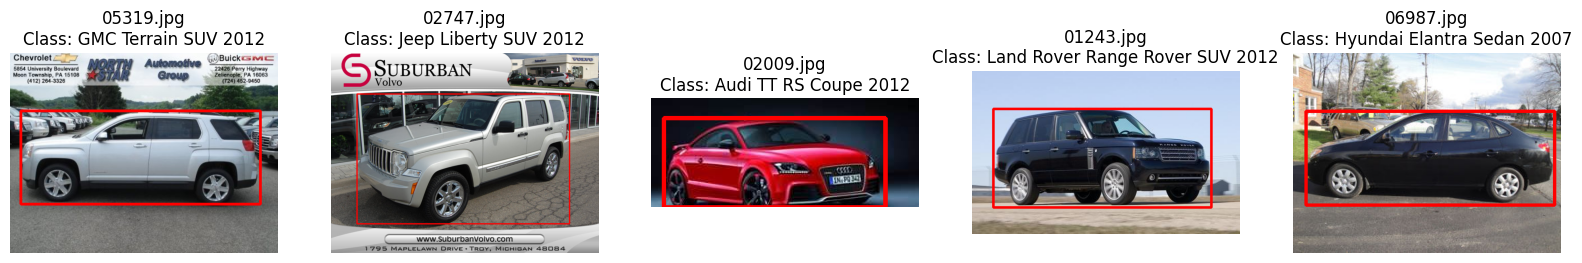

time: 833 ms (started: 2025-02-27 19:07:31 +00:00)


In [ ]:
# SECTION 3: Display Random Images with Annotations
# =====================================================


import cv2
import random


# Select 5 random images
random_samples = random.sample(train_annotations, 5)

def display_images_with_annotations(samples, dataset_path, df):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    if len(samples) < 5:
        print("Not enough images to display.")
        return

    for idx, sample in enumerate(samples):
        if len(sample) < 2:
            print(f"Skipping invalid sample: {sample}")
            continue

        image_name, class_num = sample
        image_path = os.path.join(dataset_path, "cars_train/cars_train", image_name)

        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Extract bounding box information from DataFrame
        row = df[df['image'] == image_name]
        if not row.empty:
            x1, y1, x2, y2 = int(row.iloc[0]['x1']), int(row.iloc[0]['y1']), int(row.iloc[0]['x2']), int(row.iloc[0]['y2'])
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 3)  # Draw bounding box

            # Display bounding box details
            print(f"🔹 Image: {image_name} | Class: {train_class_names[class_num]}")
            print(f"   Bounding Box → x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")

        # Display image
        title_text = f"{image_name}\nClass: {train_class_names[class_num]}"
        axes[idx].imshow(image)
        axes[idx].set_title(title_text)
        axes[idx].axis("off")

    plt.show()

# Define dataset path
dataset_path = "/content/dataset"
display_images_with_annotations(random_samples, dataset_path, train_df)


**SECTION 3.5 : Display Test images with real Classes from Excel**

Image: 00772.jpg | Class #178 → Scion xD Hatchback 2012
Image: 03599.jpg | Class #88 → Dodge Sprinter Cargo Van 2009
Image: 05697.jpg | Class #47 → Buick Regal GS 2012
Image: 00457.jpg | Class #1 → AM General Hummer SUV 2000
Image: 00792.jpg | Class #5 → Acura TSX Sedan 2012


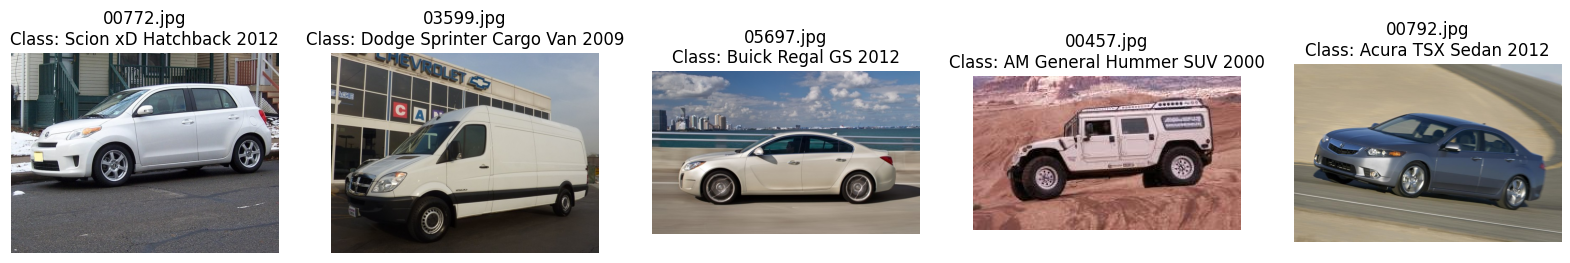

time: 1.59 s (started: 2025-02-27 19:07:32 +00:00)


In [ ]:

# Load the test dataset from Excel
metadata_path = "/content/dataset/stanford_cars_with_class_names.xlsx"
xls = pd.ExcelFile(metadata_path)
test_df = pd.read_excel(xls, sheet_name="test")

# Fix image names (remove extra quotes if they exist)
test_df["image"] = test_df["image"].astype(str).str.replace("'", "")

# Define dataset path for test images
TEST_IMAGE_PATH = "/content/dataset/cars_test/cars_test/"

# Function to display random test images
def display_random_test_images(df, dataset_path, num_samples=5):
    """
    Displays random test images along with their class names.
    """
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

    # Select random images
    samples = df.sample(n=num_samples, random_state=random.randint(0, 10000))

    for idx, (_, row) in enumerate(samples.iterrows()):
        image_name = row["image"]
        image_path = os.path.join(dataset_path, image_name)

        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Extract class information
        class_name = row["ture_class_name"]
        class_num = int(row["class"])

        # Print image details
        print(f"Image: {image_name} | Class #{class_num} → {class_name}")

        # Display image
        title_text = f"{image_name}\nClass: {class_name}"
        axes[idx].imshow(image)
        axes[idx].set_title(title_text)
        axes[idx].axis("off")

    plt.show()

# Display random test images
display_random_test_images(test_df, TEST_IMAGE_PATH, num_samples=5)


**SECTION 4: Load ResNet50 Model for Transfer Learning**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load ResNet50 model and unfreeze specific layers for training
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom fully connected layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = Dropout(0.3)(x)
output_layer = Dense(196, activation='softmax', kernel_regularizer=l2(0.0005))(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Lower learning rate for stability
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

model.summary()
print("ResNet50 Model with More Layers Unfrozen Successfully!")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,826,692 (94.71 MB)

 Trainable params: 5,700,548 (21.75 MB)

 Non-trainable params: 19,126,144 (72.96 MB)

ResNet50 Model with More Layers Unfrozen Successfully!
time: 4.5 s (started: 2025-02-27 19:09:12 +00:00)


 **SECTION 5: Preprocessing**

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define dataset paths
TRAIN_IMAGE_PATH = "/content/dataset/cars_train/cars_train/"
TEST_IMAGE_PATH = "/content/dataset/cars_test/cars_test/"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Convert class column to string format (important for ImageDataGenerator)
train_df["class"] = train_df["class"].astype(str)
test_df["class"] = test_df["class"].astype(str)

# Split data into training (80%) and validation (20%)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df["class"], random_state=42)

# Data Augmentation for training set
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Normalization for validation and test sets
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=TRAIN_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


print("Data Preprocessing Completed!")


Found 6515 validated image filenames belonging to 196 classes.
Found 1629 validated image filenames belonging to 196 classes.
Found 8041 validated image filenames belonging to 196 classes.
Data Preprocessing Completed!
time: 349 ms (started: 2025-02-27 19:09:20 +00:00)


**SECTION 6: Training the Model**


In [ ]:
EPOCHS = 80

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=1
)

print("Training complete.")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
204/204 ━━━━━━━━━━━━━━━━━━━━ 140s 587ms/step - accuracy: 0.0107 - loss: 6.3573 - top_k_categorical_accuracy: 0.0454 - val_accuracy: 0.0282 - val_loss: 5.6827 - val_top_k_categorical_accuracy: 0.1197
Epoch 2/80
204/204 ━━━━━━━━━━━━━━━━━━━━ 100s 492ms/step - accuracy: 0.0344 - loss: 5.5671 - top_k_categorical_accuracy: 0.1330 - val_accuracy: 0.0847 - val_loss: 4.9854 - val_top_k_categorical_accuracy: 0.2535
Epoch 3/80
204/204 ━━━━━━━━━━━━━━━━━━━━ 101s 496ms/step - accuracy: 0.0822 - loss: 4.9826 - top_k_categorical_accuracy: 0.2637 - val_accuracy: 0.1369 - val_loss: 4.4154 - val_top_k_categorical_accuracy: 0.4045
Epoch 4/80
204/204 ━━━━━━━━━━━━━━━━━━━━ 141s 492ms/step - accuracy: 0.1350 - loss: 4.4937 - top_k_categorical_accuracy: 0.3847 - val_accuracy: 0.1768 - val_loss: 4.1104 - val_top_k_categorical_accuracy: 0.4659
Epoch 5/80
204/204 ━━━━━━━━━━━━━━━━━━━━ 102s 498ms/step - accuracy: 0.1771 - loss: 4.1482 - top_k_categorical_accuracy: 0.4663 - val_accuracy: 0.2333 - val_loss

**Plot Training and Validation Loss**

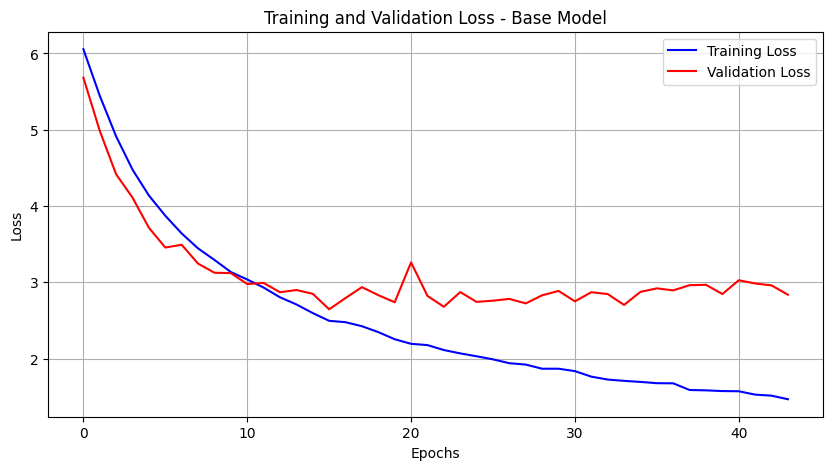

Training with Data Augmentation complete!
Final training accuracy: 0.8141
Final validation accuracy: 0.5519
time: 162 ms (started: 2025-02-27 20:28:46 +00:00)


In [ ]:

# Plot training and validation loss in the same graph
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss - Base Model")
plt.legend()
plt.grid(True)
plt.show()

# Print final accuracy results
print("Training with Data Augmentation complete!")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")


**SECTION 6: TEST THE MODEL ( transfer learning - first model)**

Found 5 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


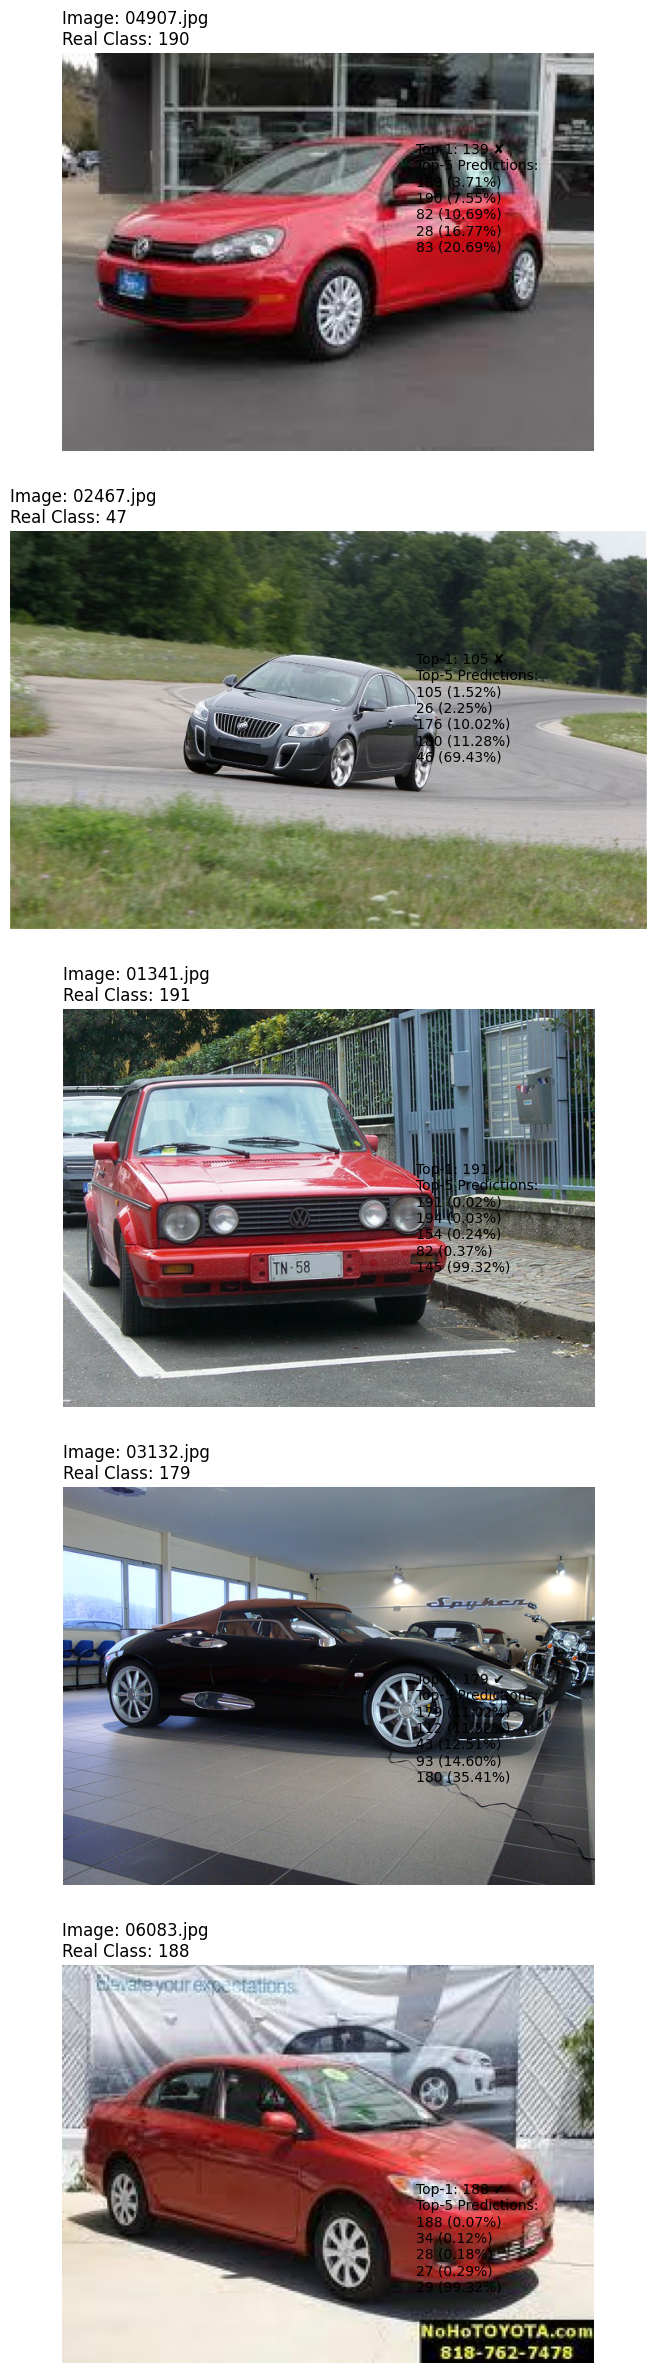

time: 8.54 s (started: 2025-02-27 20:29:04 +00:00)


In [ ]:

# Get class mapping from generator
class_indices = test_generator.class_indices  # Dictionary: {'class_name': index}
index_to_class = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Select 5 random images from the test dataset
random_indices = np.random.choice(len(test_generator.filenames), 5, replace=False)
random_images = [test_generator.filenames[i] for i in random_indices]
true_labels = [test_generator.classes[i] for i in random_indices]

# Get predictions only for the selected 5 images
sample_test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df.iloc[random_indices],
    directory=TEST_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=5,
    class_mode="categorical",
    shuffle=False
)

predictions = model.predict(sample_test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
top_5_predictions = np.argsort(predictions, axis=1)[:, -5:]
top_5_probs = np.sort(predictions, axis=1)[:, -5:]

# Display images and evaluation
fig, axes = plt.subplots(5, 1, figsize=(10, 30))
for idx, (image_name, true_label) in enumerate(zip(random_images, true_labels)):
    image_path = os.path.join(TEST_IMAGE_PATH, image_name)
    image = Image.open(image_path)

    # Map numerical labels back to class names
    true_class_name = index_to_class[true_label]
    predicted_label = predicted_classes[idx]
    predicted_class_name = index_to_class[predicted_label]

    top_5 = top_5_predictions[idx]
    top_5_confidences = top_5_probs[idx]
    correct = "✔" if predicted_label == true_label else "✘"

    # Formatting top-5 results
    top_5_text = "\n".join([f"{index_to_class[i]} ({top_5_confidences[j]*100:.2f}%)" for j, i in enumerate(top_5[::-1])])

    # Display the image
    axes[idx].imshow(image)
    axes[idx].axis("off")
    axes[idx].set_title(f"Image: {image_name}\nReal Class: {true_class_name}", fontsize=12, loc='left')

    # Add text outside the image
    plt.figtext(0.6, 0.85 - (idx * 0.17), f"Top-1: {predicted_class_name} {correct}\nTop-5 Predictions:\n{top_5_text}", fontsize=10, verticalalignment='top')

plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, top_k_accuracy_score

# Get model predictions on the test dataset
predictions = model.predict(test_generator, verbose=1)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get true class labels from the generator
true_classes = test_generator.classes

# Calculate Top-1 Accuracy (Regular Accuracy)
test_accuracy = accuracy_score(true_classes, predicted_classes)

# Calculate Top-5 Accuracy
top_5_accuracy = top_k_accuracy_score(true_classes, predictions, k=5)

# Print evaluation results
print(f" Test Accuracy (Top-1): {test_accuracy:.4f}")
print(f" Test Top-5 Accuracy: {top_5_accuracy:.4f}")


252/252 ━━━━━━━━━━━━━━━━━━━━ 50s 183ms/step
 Test Accuracy (Top-1): 0.5636
 Test Top-5 Accuracy: 0.8433
time: 50.5 s (started: 2025-02-27 20:29:21 +00:00)


**SECTION 8: Save the Trained Model**


In [ ]:
model.save('car_classification_ResNet .h5')
print("Model saved as : car_classification_ResNet .h5 ")

Model saved as : car_classification_ResNet .h5 
time: 584 ms (started: 2025-02-27 20:30:12 +00:00)


**SECTION 9: Data Augmentation - Advanced Preprocessing**

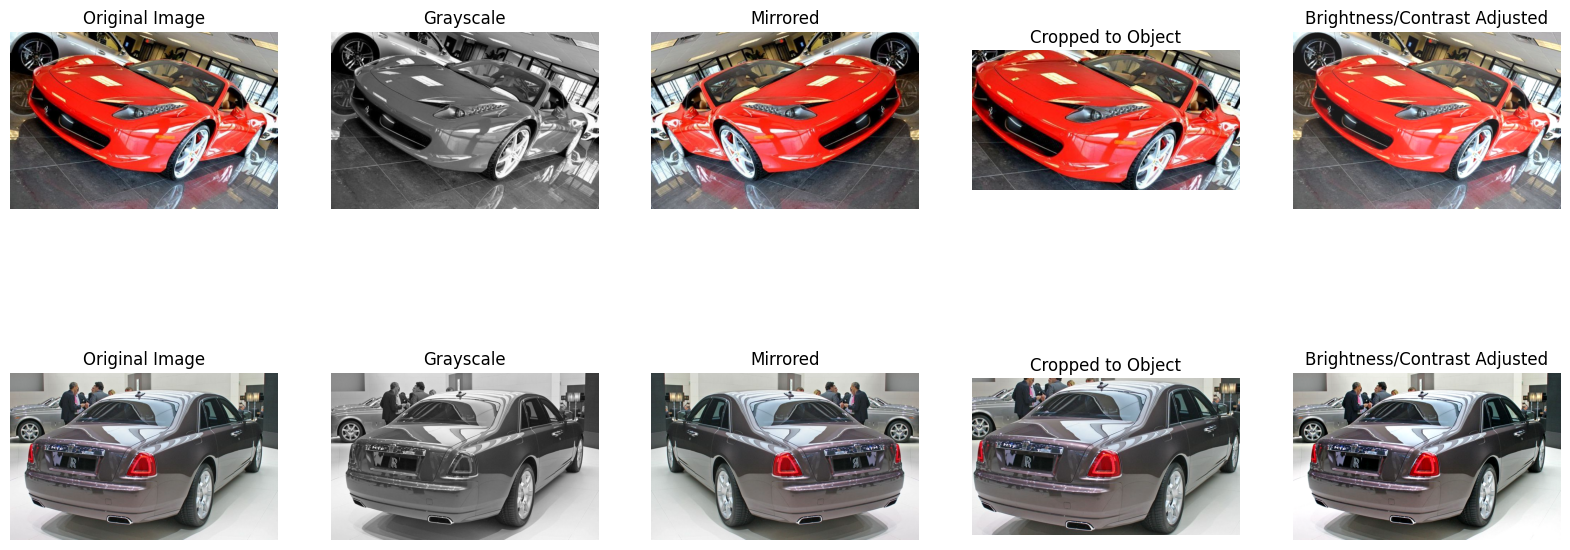

time: 808 ms (started: 2025-02-27 20:30:13 +00:00)


In [ ]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import os

# Select 2 random images
random_samples = train_df.sample(n=2, random_state=42)

# Function to convert an image to grayscale
def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Function to apply horizontal mirroring
def apply_mirror(image):
    return cv2.flip(image, 1)  # 1 = horizontal, 0 = vertical

# Function to crop the object using bounding box coordinates
def crop_to_bounding_box(image, x1, y1, x2, y2):
    return image[y1:y2, x1:x2]

# Function to randomly adjust brightness and contrast
def random_brightness_contrast(image):
    alpha = random.uniform(0.8, 1.2)  # Contrast adjustment factor
    beta = random.randint(-30, 30)  # Brightness adjustment value
    return np.clip(alpha * image + beta, 0, 255).astype(np.uint8)

# Function to display the original image alongside augmented versions
def display_augmentation_effects(samples, dataset_path):
    fig, axes = plt.subplots(len(samples), 5, figsize=(20, 8))

    for idx, row in enumerate(samples.itertuples()):
        image_name = row.image.replace("'", "")
        image_path = os.path.join(dataset_path, image_name)

        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        # Load image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Extract bounding box coordinates
        x1, y1, x2, y2 = int(row.x1), int(row.y1), int(row.x2), int(row.y2)

        # Apply transformations
        grayscale = convert_to_grayscale(image)
        mirrored = apply_mirror(image)
        cropped = crop_to_bounding_box(image, x1, y1, x2, y2)
        bright_contrast = random_brightness_contrast(image)

        # Display images
        axes[idx, 0].imshow(image)
        axes[idx, 0].set_title("Original Image")

        axes[idx, 1].imshow(grayscale, cmap="gray")
        axes[idx, 1].set_title("Grayscale")

        axes[idx, 2].imshow(mirrored)
        axes[idx, 2].set_title("Mirrored")

        axes[idx, 3].imshow(cropped)
        axes[idx, 3].set_title("Cropped to Object")

        axes[idx, 4].imshow(bright_contrast)
        axes[idx, 4].set_title("Brightness/Contrast Adjusted")

        for ax in axes[idx]:
            ax.axis("off")

    plt.show()

# Display augmented images for random samples
display_augmentation_effects(random_samples, TRAIN_IMAGE_PATH)


 **SECTION 10 : Model with Data Augmentation**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load ResNet50 model and unfreeze specific layers for training
base_model_aug = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model_aug.layers[:-10]:
    layer.trainable = False
for layer in base_model_aug.layers[-10:]:
    layer.trainable = True

# Add custom fully connected layers
x = base_model_aug.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = Dropout(0.3)(x)
output_layer = Dense(196, activation='softmax', kernel_regularizer=l2(0.0005))(x)

# Create the new model
model_aug = Model(inputs=base_model_aug.input, outputs=output_layer)

# Compile the new model with Adam optimizer and categorical crossentropy loss
model_aug.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

model_aug.summary()
print("ResNet50 Model with Data Augmentation Successfully Created!")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,826,692 (94.71 MB)

 Trainable params: 5,700,548 (21.75 MB)

 Non-trainable params: 19,126,144 (72.96 MB)

ResNet50 Model with Data Augmentation Successfully Created!
time: 2.32 s (started: 2025-02-27 20:31:23 +00:00)


**SECTION 10A: Data Augmentation and Data Preparation**


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define dataset paths
TRAIN_IMAGE_PATH = "/content/dataset/cars_train/cars_train/"
TEST_IMAGE_PATH = "/content/dataset/cars_test/cars_test/"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Convert class column to string format (important for ImageDataGenerator)
train_df["class"] = train_df["class"].astype(str)
test_df["class"] = test_df["class"].astype(str)

# Split data into training (80%) and validation (20%)
train_df_aug, val_df_aug = train_test_split(train_df, test_size=0.2, stratify=train_df["class"], random_state=42)

# Data Augmentation for training set
train_datagen_aug = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Normalization for validation and test sets
val_datagen_aug = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
test_datagen_aug = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

# Create data generators
train_generator_aug = train_datagen_aug.flow_from_dataframe(
    dataframe=train_df_aug,
    directory=TRAIN_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_generator_aug = val_datagen_aug.flow_from_dataframe(
    dataframe=val_df_aug,
    directory=TRAIN_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator_aug = test_datagen_aug.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Early Stopping to prevent overfitting
early_stopping_aug = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Reduce learning rate when validation loss plateaus

print("Data Preprocessing with Augmentation Completed!")


Found 5212 validated image filenames belonging to 196 classes.
Found 1303 validated image filenames belonging to 196 classes.
Found 8041 validated image filenames belonging to 196 classes.
Data Preprocessing with Augmentation Completed!
time: 124 ms (started: 2025-02-27 20:31:52 +00:00)


**SECTION 10C: Train Model with Data Augmentation**



In [ ]:
EPOCHS = 35  # Number of epochs for training

# Train the model with augmented data
history_aug = model_aug.fit(
    train_generator_aug,
    validation_data=val_generator_aug,  # Use the same validation set from the base model
    epochs=EPOCHS,
    callbacks=[early_stopping_aug],
    verbose=1
)

print("Training with Data Augmentation Completed!")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 711ms/step - accuracy: 0.0084 - loss: 6.4524 - top_k_categorical_accuracy: 0.0442 - val_accuracy: 0.0238 - val_loss: 5.8154 - val_top_k_categorical_accuracy: 0.0898
Epoch 2/35
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 551ms/step - accuracy: 0.0339 - loss: 5.6581 - top_k_categorical_accuracy: 0.1197 - val_accuracy: 0.0507 - val_loss: 5.3616 - val_top_k_categorical_accuracy: 0.1727
Epoch 3/35
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 554ms/step - accuracy: 0.0772 - loss: 5.1392 - top_k_categorical_accuracy: 0.2384 - val_accuracy: 0.0906 - val_loss: 4.7861 - val_top_k_categorical_accuracy: 0.3001
Epoch 4/35
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 556ms/step - accuracy: 0.0985 - loss: 4.6983 - top_k_categorical_accuracy: 0.3214 - val_accuracy: 0.1765 - val_loss: 4.1764 - val_top_k_categorical_accuracy: 0.4612
Epoch 5/35
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 551ms/step - accuracy: 0.1483 - loss: 4.3953 - top_k_categorical_accuracy: 0.4143 - val_accuracy: 0.1673 - val_loss: 4.

**Plot Training and Validation Loss**

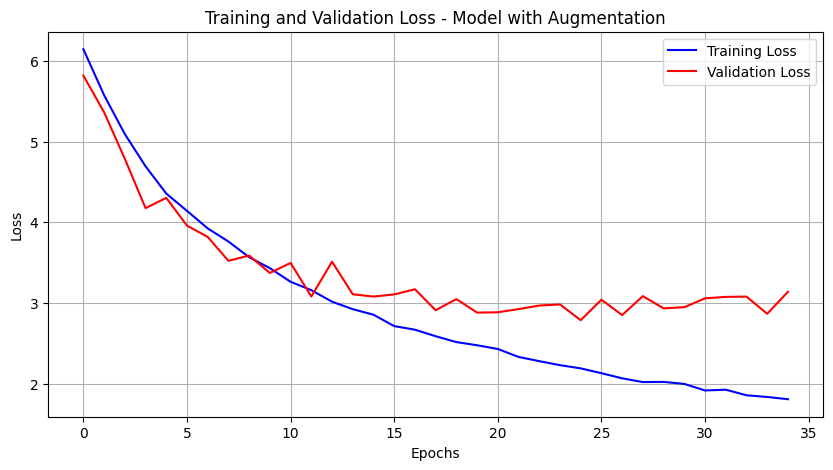

Training with Data Augmentation Completed!
Final training accuracy: 0.7306
Final validation accuracy: 0.4904
time: 187 ms (started: 2025-02-27 21:28:28 +00:00)


In [ ]:
# Plot training and validation loss in the same graph
plt.figure(figsize=(10, 5))
plt.plot(history_aug.history["loss"], label="Training Loss", color="blue")
plt.plot(history_aug.history["val_loss"], label="Validation Loss", color="red")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss - Model with Augmentation")
plt.legend()
plt.grid(True)
plt.show()

# Print final accuracy results
print("Training with Data Augmentation Completed!")
print(f"Final training accuracy: {history_aug.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history_aug.history['val_accuracy'][-1]:.4f}")


**SECTION 11: Evaluate the Augmented Model on Test Data**


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, top_k_accuracy_score

# Get model predictions on the test dataset
predictions_aug = model_aug.predict(test_generator_aug, verbose=1)

# Convert predictions to class indices
predicted_classes_aug = np.argmax(predictions_aug, axis=1)

# Get true class labels from the generator
true_classes_aug = test_generator_aug.classes

# Calculate Top-1 Accuracy (Regular Accuracy)
test_accuracy_aug = accuracy_score(true_classes_aug, predicted_classes_aug)

# Calculate Top-5 Accuracy
top_5_accuracy_aug = top_k_accuracy_score(true_classes_aug, predictions_aug, k=5)

# Print evaluation results
print(f"Test Accuracy (Top-1): {test_accuracy_aug:.4f}")
print(f"Test Top-5 Accuracy: {top_5_accuracy_aug:.4f}")


252/252 ━━━━━━━━━━━━━━━━━━━━ 49s 180ms/step
Test Accuracy (Top-1): 0.5212
Test Top-5 Accuracy: 0.8207
time: 49.4 s (started: 2025-02-27 21:28:28 +00:00)


**SECTION 12 : Saving the model_augmented Model**

In [ ]:
model_aug.save('model_augmented_resnet50.h5')
print("Model saved as : model_augmented_resnet50.h5 ")

Model saved as : model_augmented_resnet50.h5 
time: 954 ms (started: 2025-02-27 21:29:17 +00:00)


**SECTION 13A: Prepare the Third Model (Fine-Tuned Model)**


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load ResNet50 model and unfreeze more layers for fine-tuning
base_model_finetuned = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model_finetuned.layers[:-20]:
    layer.trainable = False
for layer in base_model_finetuned.layers[-20:]:
    layer.trainable = True

# Add custom fully connected layers
x = base_model_finetuned.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = Dropout(0.2)(x)
output_layer = Dense(196, activation='softmax', kernel_regularizer=l2(0.0005))(x)

# Create the fine-tuned model
model_finetuned = Model(inputs=base_model_finetuned.input, outputs=output_layer)

# Compile the fine-tuned model
model_finetuned.compile(
    optimizer=Adam(learning_rate=0.0005),  # Lower learning rate for better fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

model_finetuned.summary()
print("Fine-Tuned ResNet50 Model with Data Augmentation Successfully Created!")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 26,400,580 (100.71 MB)

 Trainable params: 11,740,100 (44.78 MB)

 Non-trainable params: 14,660,480 (55.93 MB)

Fine-Tuned ResNet50 Model with Data Augmentation Successfully Created!
time: 1.21 s (started: 2025-02-27 21:35:44 +00:00)


**SECTION 13B: Data Augmentation and Data Preparation**


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define dataset paths
TRAIN_IMAGE_PATH = "/content/dataset/cars_train/cars_train/"
TEST_IMAGE_PATH = "/content/dataset/cars_test/cars_test/"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

# Convert class column to string format
train_df["class"] = train_df["class"].astype(str)
test_df["class"] = test_df["class"].astype(str)

# Split data into training (80%) and validation (20%)
train_df_finetuned, val_df_finetuned = train_test_split(train_df, test_size=0.2, stratify=train_df["class"], random_state=42)

# Data Augmentation for fine-tuned model
train_datagen_finetuned = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

# Normalization for validation and test sets
val_datagen_finetuned = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
test_datagen_finetuned = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

# Create data generators
train_generator_finetuned = train_datagen_finetuned.flow_from_dataframe(
    dataframe=train_df_finetuned,
    directory=TRAIN_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_generator_finetuned = val_datagen_finetuned.flow_from_dataframe(
    dataframe=val_df_finetuned,
    directory=TRAIN_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator_finetuned = test_datagen_finetuned.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_IMAGE_PATH,
    x_col="image",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Early Stopping to prevent overfitting
early_stopping_finetuned = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Reduce learning rate when validation loss plateaus
reduce_lr_finetuned = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-3)

print("Data Preprocessing with Augmentation for Fine-Tuned Model Completed!")


Found 5212 validated image filenames belonging to 196 classes.
Found 1303 validated image filenames belonging to 196 classes.
Found 8041 validated image filenames belonging to 196 classes.
Data Preprocessing with Augmentation for Fine-Tuned Model Completed!
time: 112 ms (started: 2025-02-27 21:35:59 +00:00)


**SECTION 13C: Load & Compile Fine-Tuned Model with Data Augmentation**

In [ ]:
EPOCHS = 80  # More epochs for fine-tuning

# Train the fine-tuned model
history_finetuned = model_finetuned.fit(
    train_generator_finetuned,
    validation_data=val_generator_finetuned,
    epochs=EPOCHS,
    callbacks=[early_stopping_finetuned, reduce_lr_finetuned],
    verbose=1
)

print("Training for Fine-Tuned Model with Data Augmentation Completed!")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80
326/326 ━━━━━━━━━━━━━━━━━━━━ 137s 356ms/step - accuracy: 0.0045 - loss: 6.8909 - top_k_categorical_accuracy: 0.0285 - val_accuracy: 0.0084 - val_loss: 6.5604 - val_top_k_categorical_accuracy: 0.0537 - learning_rate: 5.0000e-04
Epoch 2/80
326/326 ━━━━━━━━━━━━━━━━━━━━ 117s 309ms/step - accuracy: 0.0119 - loss: 6.4266 - top_k_categorical_accuracy: 0.0630 - val_accuracy: 0.0269 - val_loss: 6.1342 - val_top_k_categorical_accuracy: 0.0975 - learning_rate: 5.0000e-04
Epoch 3/80
326/326 ━━━━━━━━━━━━━━━━━━━━ 98s 300ms/step - accuracy: 0.0216 - loss: 6.0743 - top_k_categorical_accuracy: 0.0954 - val_accuracy: 0.0399 - val_loss: 5.6423 - val_top_k_categorical_accuracy: 0.1558 - learning_rate: 5.0000e-04
Epoch 4/80
326/326 ━━━━━━━━━━━━━━━━━━━━ 99s 303ms/step - accuracy: 0.0433 - loss: 5.7403 - top_k_categorical_accuracy: 0.1461 - val_accuracy: 0.0668 - val_loss: 5.1971 - val_top_k_categorical_accuracy: 0.2678 - learning_rate: 5.0000e-04
Epoch 5/80
326/326 ━━━━━━━━━━━━━━━━━━━━ 98s 300ms/

 **Plot Training and Validation Loss**


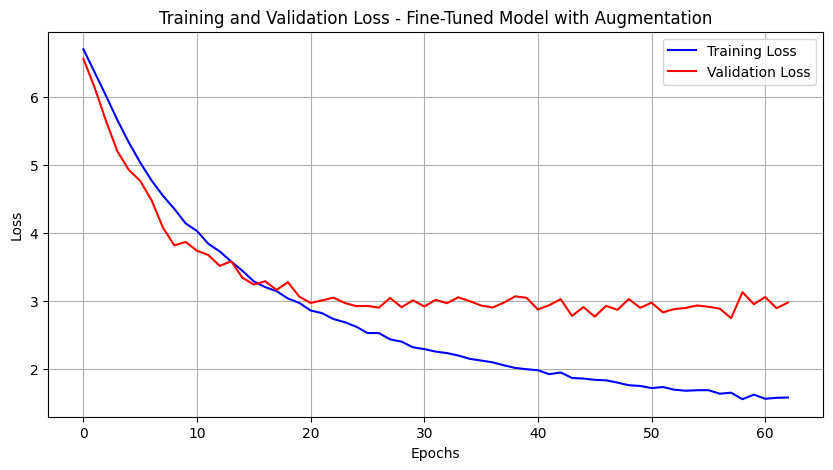

Training for Fine-Tuned Model Completed!
Final training accuracy: 0.8260
Final validation accuracy: 0.5595
time: 172 ms (started: 2025-02-27 23:22:49 +00:00)


In [ ]:
# Plot training and validation loss in the same graph
plt.figure(figsize=(10, 5))
plt.plot(history_finetuned.history["loss"], label="Training Loss", color="blue")
plt.plot(history_finetuned.history["val_loss"], label="Validation Loss", color="red")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss - Fine-Tuned Model with Augmentation")
plt.legend()
plt.grid(True)
plt.show()

# Print final accuracy results
print("Training for Fine-Tuned Model Completed!")
print(f"Final training accuracy: {history_finetuned.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history_finetuned.history['val_accuracy'][-1]:.4f}")


**SECTION 13C: Evaluate the Fine-Tuned Model**


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, top_k_accuracy_score

# Get model predictions on the test dataset
predictions_finetuned = model_finetuned.predict(test_generator_finetuned, verbose=1)

# Convert predictions to class indices
predicted_classes_finetuned = np.argmax(predictions_finetuned, axis=1)

# Get true class labels from the generator
true_classes_finetuned = test_generator_finetuned.classes

# Calculate Top-1 Accuracy (Regular Accuracy)
test_accuracy_finetuned = accuracy_score(true_classes_finetuned, predicted_classes_finetuned)

# Calculate Top-5 Accuracy
top_5_accuracy_finetuned = top_k_accuracy_score(true_classes_finetuned, predictions_finetuned, k=5)

# Print evaluation results
print(f"Test Accuracy (Top-1): {test_accuracy_finetuned:.4f}")
print(f"Test Top-5 Accuracy: {top_5_accuracy_finetuned:.4f}")


503/503 ━━━━━━━━━━━━━━━━━━━━ 50s 92ms/step
Test Accuracy (Top-1): 0.5685
Test Top-5 Accuracy: 0.8487
time: 50.4 s (started: 2025-02-27 23:22:49 +00:00)


**SECTION 14 : Saving the finetuned Model**

In [ ]:
model_finetuned.save('model_finetuned.h5')
print("Model saved as : model_finetuned.h5 ")

Model saved as : model_finetuned.h5 
time: 746 ms (started: 2025-02-27 23:23:40 +00:00)


***SECTION 15: Compare Models Performance***


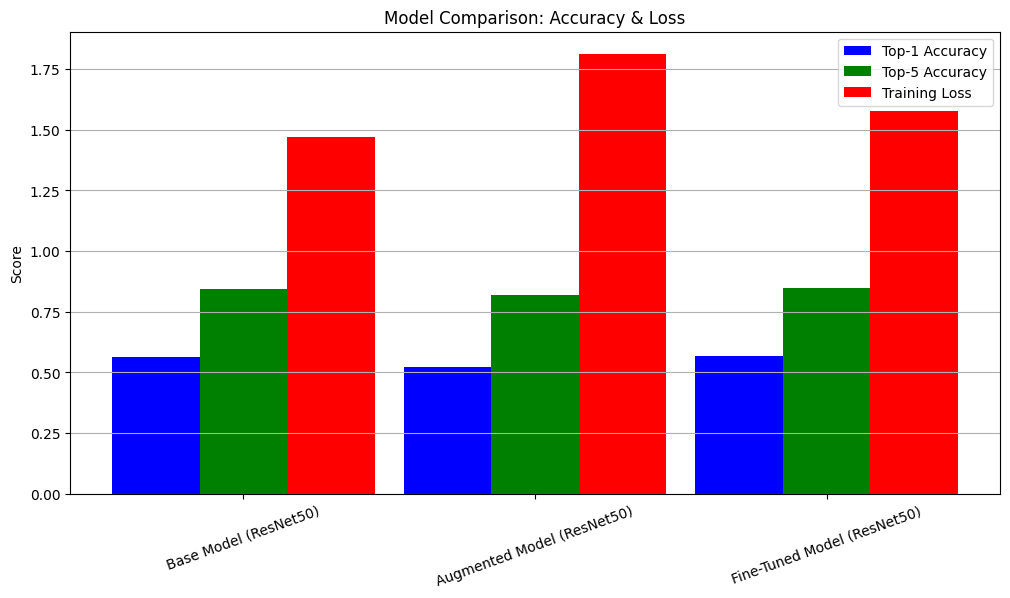

=== Model Performance Summary ===
Base Model (ResNet50):
  - Test Accuracy (Top-1): 0.5636
  - Test Accuracy (Top-5): 0.8433
  - Training Loss: 1.4691
----------------------------------------
Augmented Model (ResNet50):
  - Test Accuracy (Top-1): 0.5212
  - Test Accuracy (Top-5): 0.8207
  - Training Loss: 1.8132
----------------------------------------
Fine-Tuned Model (ResNet50):
  - Test Accuracy (Top-1): 0.5685
  - Test Accuracy (Top-5): 0.8487
  - Training Loss: 1.5762
----------------------------------------
time: 192 ms (started: 2025-02-27 23:23:40 +00:00)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Store the model names for labeling
models = ["Base Model (ResNet50)", "Augmented Model (ResNet50)", "Fine-Tuned Model (ResNet50)"]

# Store accuracy and top-5 accuracy results from each model
test_accuracies = [test_accuracy, test_accuracy_aug, test_accuracy_finetuned]
top_5_accuracies = [top_5_accuracy, top_5_accuracy_aug, top_5_accuracy_finetuned]
test_losses = [history.history["loss"][-1], history_aug.history["loss"][-1], history_finetuned.history["loss"][-1]]

# Create a bar plot to compare test accuracies and losses
plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.3  # Bar width

plt.bar(x - width, test_accuracies, width=width, label="Top-1 Accuracy", color="blue")
plt.bar(x, top_5_accuracies, width=width, label="Top-5 Accuracy", color="green")
plt.bar(x + width, test_losses, width=width, label="Training Loss", color="red")

# Labels and formatting
plt.xticks(x, models, rotation=20)
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy & Loss")
plt.legend()
plt.grid(axis="y")

# Show plot
plt.show()

# Print results for quick comparison
print("=== Model Performance Summary ===")
for i in range(len(models)):
    print(f"{models[i]}:")
    print(f"  - Test Accuracy (Top-1): {test_accuracies[i]:.4f}")
    print(f"  - Test Accuracy (Top-5): {top_5_accuracies[i]:.4f}")
    print(f"  - Training Loss: {test_losses[i]:.4f}")
    print("-" * 40)


End Of Transfer Learning